In [267]:
import numpy as np
import matplotlib.pyplot as plt

In [268]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

#### 載入mnist資料集

In [269]:
# Load dataset
(x_train, y_train0), (x_test, y_test0) = datasets.mnist.load_data()

# Reshape size
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Normalize the range of featurs
x_train = x_train / 255
x_test = x_test / 255

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

#### 架構VAE模型
* Encoder層和和Decoder層分別設三層，activation改用tanh，batch_size=256,epochs=25

In [270]:
x = Input(shape=(784,))
enc_1 = Dense(100, activation='tanh')
enc_2 = Dense(64, activation='tanh')
enc_3 = Dense(32, activation='tanh')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(100, activation='tanh')
dec_2 = Dense(394, activation='tanh')
dec_1 = Dense(784, activation='tanh')

In [271]:
enc_x = enc_3(enc_2(enc_1(x)))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [272]:
#定義抽樣函數
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [273]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [274]:
x_hat = dec_1(dec_2(dec_3(z)))

In [275]:
VAE = Model(x, x_hat)
VAE.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 100)          78500       input_18[0][0]                   
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 64)           6464        dense_64[0][0]                   
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 32)           2080        dense_65[0][0]                   
___________________________________________________________________________________________

In [276]:
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [277]:
VAE.compile(optimizer=Adam())

In [278]:
VAE.fit(x_train,batch_size=256,epochs=25)

Train on 60000 samples
Epoch 1/25
60000/60000 [==============================] - 5s 85us/sample - loss: 50.6550
Epoch 2/25
60000/60000 [==============================] - 4s 69us/sample - loss: 46.8831
Epoch 3/25
60000/60000 [==============================] - 4s 68us/sample - loss: 45.7302
Epoch 4/25
60000/60000 [==============================] - 4s 68us/sample - loss: 44.1060
Epoch 5/25
60000/60000 [==============================] - 4s 68us/sample - loss: 42.5062
Epoch 6/25
60000/60000 [==============================] - 4s 68us/sample - loss: 41.8175
Epoch 7/25
60000/60000 [==============================] - 4s 68us/sample - loss: 41.2751
Epoch 8/25
60000/60000 [==============================] - 4s 69us/sample - loss: 40.8370
Epoch 9/25
60000/60000 [==============================] - 4s 69us/sample - loss: 40.4429
Epoch 10/25
60000/60000 [==============================] - 4s 69us/sample - loss: 40.1187
Epoch 11/25
60000/60000 [==============================] - 4s 69us/sample - loss: 39.8

#### 架構VAE_Encoder和VAE_Decoder

In [279]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_65 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_66 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_67 (Dense)             (None, 2)                 66        
Total params: 87,110
Trainable params: 87,110
Non-trainable params: 0
_________________________________________________________________


In [280]:
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [281]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))

VAE_Decoder.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_70 (Dense)             (None, 394)               39794     
_________________________________________________________________
dense_71 (Dense)             (None, 784)               309680    
Total params: 349,774
Trainable params: 349,774
Non-trainable params: 0
_________________________________________________________________


#### 模型視覺化

In [282]:
idx = np.random.randint(x_train.shape[0], size=5000)
#print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(x_train[idx: idx+1]).squeeze()}")

In [283]:
idx

array([37562, 23839,  3454, ..., 32388, 42228, 24242])

In [284]:
VAE_latents = VAE_Encoder.predict(x_train[idx])

In [285]:
y_train[idx]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

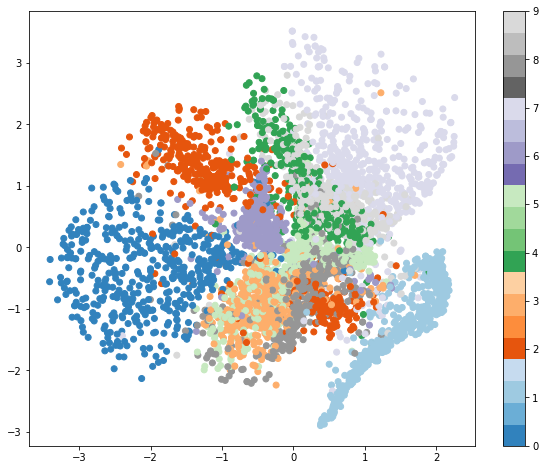

In [286]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[idx], cmap='tab20c')
plt.colorbar()
plt.show()

In [287]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [288]:
n=16
digit_size=28


In [289]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

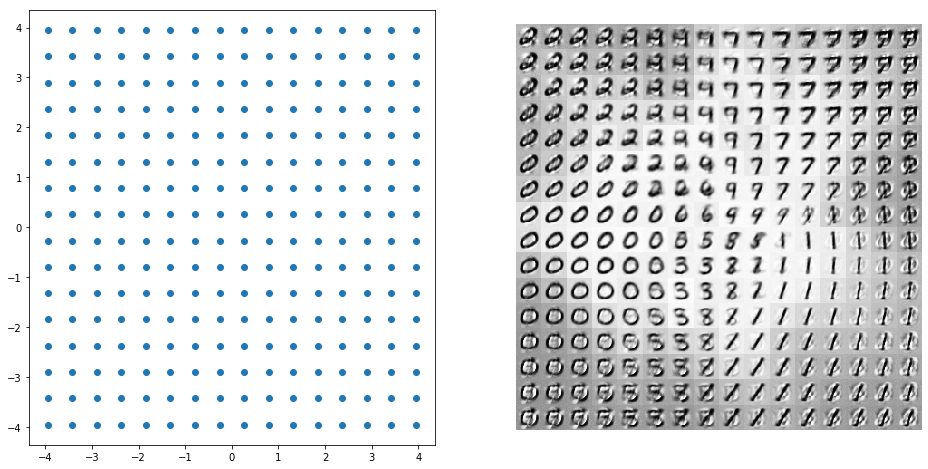

In [290]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()